In [158]:
import kagglehub

In [159]:
path = kagglehub.dataset_download("vinayakshanawad/cement-manufacturing-concrete-dataset")


In [160]:
print("Path to dataset files:", path)





Path to dataset files: /data/ephemeral/home/.cache/kagglehub/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset/versions/1


In [161]:
import pandas as pd
df = pd.read_csv(path + "/concrete.csv")

df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [162]:
df.corr()


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplastic,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseagg,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineagg,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


In [163]:
import torch

In [164]:
import sklearn

In [165]:
train,test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)

In [166]:
class ConcreteDataset(torch.utils.data.Dataset):
    def __init__(self, df, mean,std):
        self.df = df
        self.mean = mean
        self.std = std


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = self.df.iloc[idx][['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']].to_numpy()
        y = self.df.iloc[idx][['strength']].to_numpy()
        x = torch.tensor(x, dtype=torch.float32)    
        y = torch.tensor(y, dtype=torch.float32)
        x = (x - self.mean[:-1]) / self.std[:-1]
        # y = (y - self.mean[7]) / self.std[7]
        y = torch.log(y)
        # if self.transform:
        #     x = self.transform(x)
            
        return x, y

In [167]:
# dataset = ConcreteDataset(df)

# dataset[0]

In [168]:
mean = train.sample(800)[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age','strength']].to_numpy().mean(axis=0)
std = train.sample(800)[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age','strength']].to_numpy().std(axis=0)
mean = torch.tensor(mean, dtype=torch.float32)
std = torch.tensor(std, dtype=torch.float32)

In [169]:
# import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
dataset = ConcreteDataset(df,mean,std)


In [170]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset, batch_size=10, shuffle=False)

In [197]:
class simple_nn(torch.nn.Module):
    def __init__(self):
        super(simple_nn, self).__init__()
        self.fc1 = torch.nn.Linear(8, 16)
        self.fc2 = torch.nn.Linear(16, 32)
        self.fc3 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        xf = self.fc3(x)
        return xf,x
model = simple_nn()


In [198]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [199]:
import numpy as np
losses = []
val_losses = []
errors = []
for i in range(100):
    for inputs, outputs in train_loader:
        model.zero_grad()
        pred,_ = model(inputs)
        loss = torch.nn.MSELoss()(pred, outputs)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    err = []
    for inputs, outputs in test_loader:
        pred,_ = model(inputs)
        loss = torch.nn.MSELoss()(pred, outputs)
        val_losses.append(loss.item())
        err.append(abs(torch.exp(pred.detach().cpu())- torch.exp(outputs.detach().cpu())).numpy())
    errors.append(np.mean(err))

    print(f'losses: {np.mean(losses)}')
    print(f'val_losses: {np.mean(val_losses)}')
    print(f'errors: {np.mean(errors)}')

losses: 5.944651595597128
val_losses: 1.1802076807299864
errors: 23.484193801879883
losses: 3.2729539567405737
val_losses: 0.8214344070519058
errors: 21.989242553710938
losses: 2.32602618297134
val_losses: 0.6790435513825093
errors: 20.696950912475586
losses: 1.8380256560133788
val_losses: 0.5950732716693751
errors: 19.689598083496094
losses: 1.5358820665953228
val_losses: 0.5358253620637273
errors: 18.671611785888672
losses: 1.3268175418865429
val_losses: 0.4896593677500884
errors: 17.837934494018555
losses: 1.1726757253929663
val_losses: 0.45226314079000945
errors: 17.104047775268555
losses: 1.0535513137521457
val_losses: 0.421068701133566
errors: 16.43047332763672
losses: 0.9582249181990099
val_losses: 0.39541516103003144
errors: 15.858128547668457
losses: 0.8799381632394003
val_losses: 0.3725935741608004
errors: 15.335042953491211
losses: 0.8145505169115547
val_losses: 0.3523526839050485
errors: 14.838301658630371
losses: 0.7589003514531626
val_losses: 0.3345550436641069
errors: 14

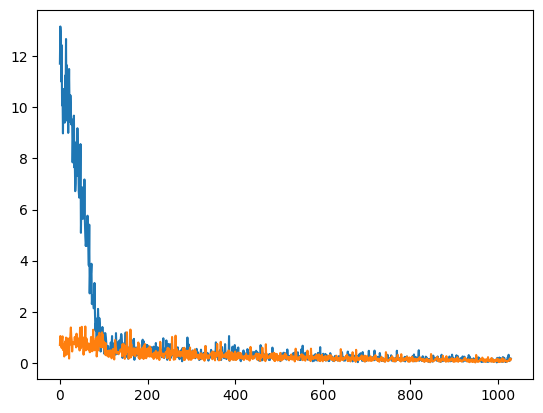

In [194]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.show()


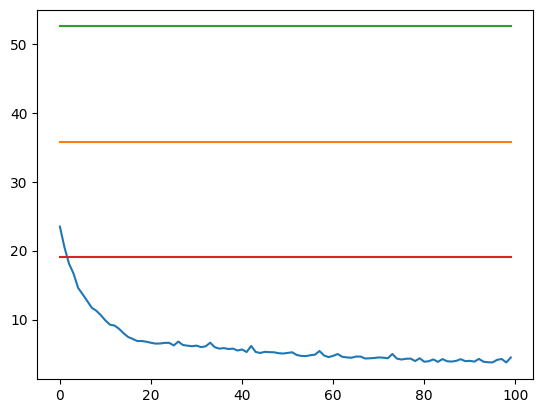

In [202]:
plt.plot(errors)
plt.plot(len(errors)*[np.mean(df['strength'].to_numpy())])
plt.plot(len(errors)*[np.mean(df['strength'].to_numpy())+np.std(df['strength'].to_numpy())])
plt.plot(len(errors)*[np.mean(df['strength'].to_numpy())-np.std(df['strength'].to_numpy())])
plt.show()

(array([ 1.,  1.,  1.,  3.,  2.,  5.,  7.,  7.,  4., 14.,  7., 11., 15.,
        18.,  9., 18., 18.,  5., 16., 16.,  6., 11.,  9., 13., 15., 14.,
        23., 21., 24., 20., 11., 16., 11., 16., 18., 12., 23., 19., 34.,
        21., 14., 15., 16., 23., 19., 22., 27., 16., 25., 19., 10., 16.,
        23.,  6., 13., 11.,  8.,  9.,  7.,  9., 15.,  8., 13., 12.,  8.,
        10., 15., 13.,  5.,  1.,  8.,  5.,  6.,  6.,  7.,  2.,  3.,  6.,
         4.,  5.,  8.,  5.,  3.,  2.,  1.,  5.,  4.,  1.,  3.,  4.,  2.,
         1.,  2.,  4.,  0.,  5.,  2.,  1.,  1.,  1.]),
 array([ 2.33  ,  3.1327,  3.9354,  4.7381,  5.5408,  6.3435,  7.1462,
         7.9489,  8.7516,  9.5543, 10.357 , 11.1597, 11.9624, 12.7651,
        13.5678, 14.3705, 15.1732, 15.9759, 16.7786, 17.5813, 18.384 ,
        19.1867, 19.9894, 20.7921, 21.5948, 22.3975, 23.2002, 24.0029,
        24.8056, 25.6083, 26.411 , 27.2137, 28.0164, 28.8191, 29.6218,
        30.4245, 31.2272, 32.0299, 32.8326, 33.6353, 34.438 , 35.2407,
        

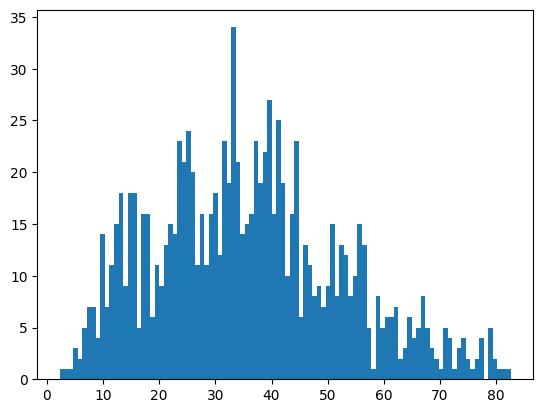

In [203]:
# df['strength'].to_numpy()
plt.hist(df['strength'].to_numpy(),bins=100)

In [204]:
feature_list = []
for inputs, outputs in test_loader:
    pred,features = model(inputs)
    features = features.detach().numpy()
    feature_list.extend(features)
feature_list = np.array(feature_list)

In [205]:
feature_list.shape

(1030, 32)

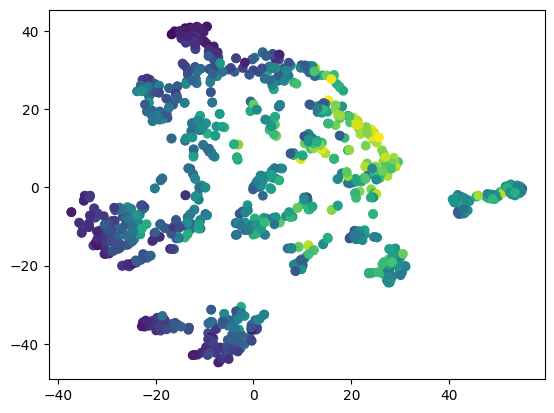

In [206]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne.fit_transform(feature_list)
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=df['strength'].to_numpy())
plt.show()

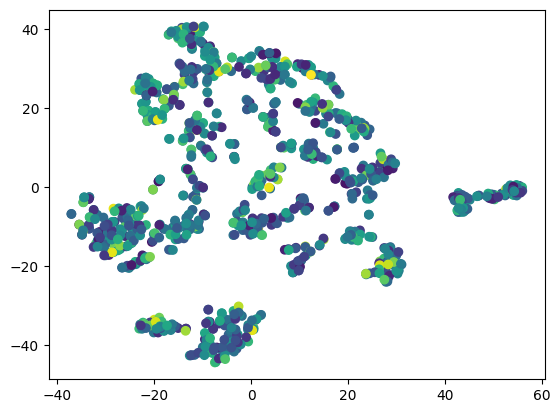

In [207]:
feature_list = []
for inputs, outputs in train_loader:
    pred,features = model(inputs)
    features = features.detach().numpy()
    feature_list.extend(features)
feature_list = np.array(feature_list)
tsne.fit_transform(feature_list)
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=df['strength'].to_numpy())
plt.show()

In [208]:
model

simple_nn(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [210]:
import tqdm

In [245]:
flag = 0
save = []
patience = 10
lr_decay_factor = 0.5  
for x,y in tqdm.tqdm(test_loader):

    # print(x.shape)
    # brewa
    y_opt = y.detach()
    init_x = torch.randn(10,8).requires_grad_(True)
    # init_x = mean[:-1].expand(10,8).clone().requires_grad_(True)
    init_x.requires_grad = True
    optimizer = optim.Adam([init_x], lr=0.1)
    
    
    for param in model.parameters():
        param.requires_grad = False

    min_val = 1e6
    min_x = None

    no_improve_epochs = 0

    for i in range(10000):
        optimizer.zero_grad()
        # with torch.no_grad():
        pred,features = model(init_x)
        loss = torch.nn.MSELoss()(pred, y_opt)
        loss.backward()
        optimizer.step()
        if loss.item() < min_val:
            min_val = loss.item()
            min_x = abs(init_x.detach().cpu()*std[:-1] - x.detach().cpu()*std[:-1])
            # print(min_x.mean())
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs > patience:
            optimizer.param_groups[0]['lr'] *= lr_decay_factor
            # print(f'lr decayed to {optimizer.param_groups[0]["lr"]}')
            no_improve_epochs = 0
        # print((init_x.detach().cpu() - x.cpu()).numpy().mean())
    
    save.append(min_x)
    


100%|██████████| 103/103 [11:14<00:00,  6.55s/it]


In [138]:
# save = torch.tensor(np.array(save))*std[7] + mean[7]


In [240]:
std# np.concatenate(save1,axis=0).shape

tensor([104.3729,  87.0870,  64.0707,  21.2558,   5.9224,  76.6144,  80.4702,
         63.7537,  16.6612])

In [246]:
save1 = torch.Tensor(np.concatenate(save,axis=0))


In [247]:
save1.shape

torch.Size([1030, 8])

(array([ 1.,  0.,  0.,  1.,  4.,  2.,  4.,  2.,  5.,  5.,  3.,  6.,  4.,
         6., 12., 11., 20., 13.,  9., 23., 16., 19., 27., 20., 21., 18.,
        29., 28., 30., 31., 32., 23., 26., 23., 25., 38., 25., 24., 25.,
        27., 22., 20., 22., 24., 20., 25., 24., 32., 17., 20., 10.,  9.,
        14., 15.,  7.,  7.,  4., 12., 11.,  5.,  5.,  3.,  4.,  7.,  3.,
         2.,  7.,  2.,  1.,  4.,  4.,  3.,  1.,  1.,  2.,  1.,  2.,  2.,
         1.,  1.,  4.,  2.,  2.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 16.12396812,  17.73231316,  19.34065628,  20.94900131,
         22.55734634,  24.16569138,  25.7740345 ,  27.38237953,
         28.99072456,  30.5990696 ,  32.20741272,  33.81575775,
         35.42410278,  37.03244781,  38.64079285,  40.24913406,
         41.8574791 ,  43.46582413,  45.07416916,  46.68251419,
         48.29085922,  49.89920425,  51.50754929,  53.1158905 ,
         54.72423553,  56.33258057,  57.9409256 , 

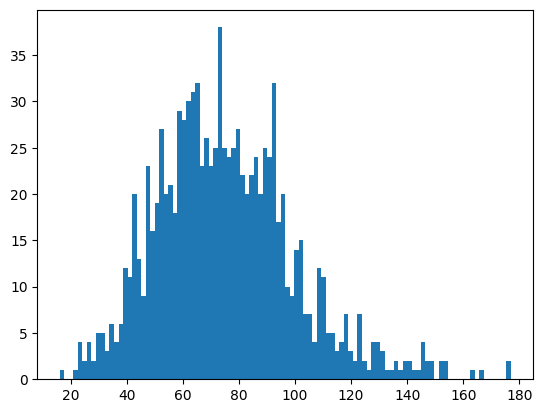

In [249]:
plt.hist(save1.mean(axis=1),bins=100)


(array([62., 53., 69., 67., 76., 49., 53., 54., 59., 52., 35., 38., 32.,
        23., 18., 21., 20., 24., 17., 13., 17., 20., 14.,  7.,  5.,  9.,
         7., 10.,  6.,  6.,  9.,  6.,  9.,  4.,  4.,  2.,  4.,  2.,  4.,
         3.,  3.,  1.,  3.,  4.,  2.,  2.,  0.,  2.,  2.,  1.,  1.,  3.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,
         0.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.36566162e-03, 4.63473272e+00, 9.26809978e+00, 1.39014673e+01,
        1.85348339e+01, 2.31682014e+01, 2.78015690e+01, 3.24349365e+01,
        3.70683022e+01, 4.17016678e+01, 4.63350372e+01, 5.09684029e+01,
        5.56017723e+01, 6.02351379e+01, 6.48685074e+01, 6.95018692e+01,
        7.41352386e+01, 7.87686081e+01, 8.34019699e+01, 8.80353394e+01,
        9.26687088e+01, 9.73020706e+01, 1.01935440e+02, 1.06568810e+02,
  

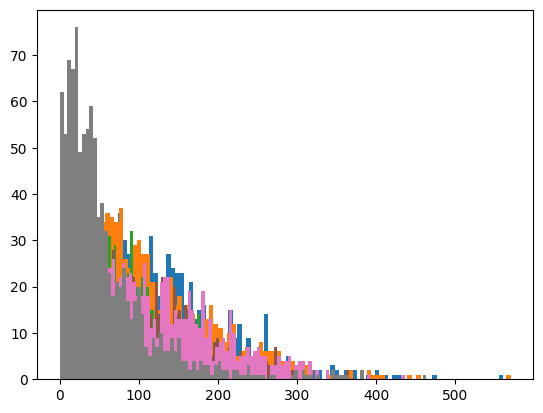

In [248]:
plt.hist(save1[:,0],bins=100)
plt.hist(save1[:,1],bins=100)
plt.hist(save1[:,2],bins=100)
plt.hist(save1[:,3],bins=100)
plt.hist(save1[:,4],bins=100)
plt.hist(save1[:,5],bins=100)
plt.hist(save1[:,6],bins=100)
plt.hist(save1[:,7],bins=100)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  2.,  5.,  7.,  3., 10., 11., 13.,  9., 19., 15.,
        11.,  6., 19., 20.,  8., 19., 13., 12., 13., 11.,  5., 14.,  9.,
        10., 10.,  6.,  9., 18., 17., 11.,  7.,  8.,  9., 13., 13., 11.,
         7.,  5.,  3.,  6.,  7.,  4.,  5.,  2.,  3.,  4.,  1.,  7.,  7.,
         6.,  3.,  2.,  2.,  1.,  1.,  0.,  1.,  1.,  3.,  0.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([568.82244873, 569.54467773, 570.26690674, 570.98913574,
        571.71136475, 572.43359375, 573.15582275, 573.87805176,
        574.60028076, 575.32250977, 576.04467773, 576.76690674,
        577.48913574, 578.21136475, 578.93359375, 579.65582275,
        580.37805176, 581.10028076, 581.82250977, 582.54473877,
        583.26696777, 583.98919678, 584.71142578, 585.43365479,
        586.15588379, 586.87811279, 587.6003418 , 

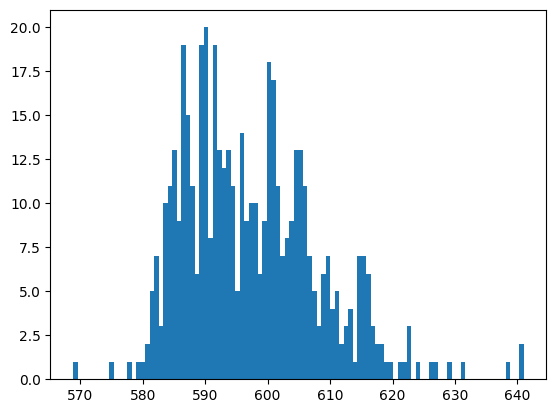

In [221]:
plt.hist(save1.mean(axis=1),bins=100)


In [154]:
std

tensor([103.7299,  87.5987,  63.7379,  21.3921,   5.9165,  76.1287,  80.1190,
         63.6713,  16.6320])

In [155]:
mean

tensor([279.3396,  75.9091,  53.5494, 182.0205,   6.1600, 973.1346, 772.6256,
         46.0563,  35.8011])